In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

from utils import nmf, plot_nmf_components, plot_reconstructed_images

In [2]:
n = 100 # n samples
m = 25 # m features
r = 20

np.random.seed(0)
X = np.abs(np.random.randn(n,m))

# Apply NMF
model = nmf(n_components=r, max_iter=1500, random_state=42, verbose=True)
W = model.fit_transform(X)
H = model.H

# Check reconstruction
X_reconstructed = model.inverse_transform() # W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nFinal reconstruction error: {error:.4f}")

Iteration 500/1500, error: 10.1601
Iteration 1000/1500, error: 10.0173
Iteration 1500/1500, error: 9.9888

Final reconstruction error: 9.9888


# NMS for Facial Feature Extraction

In [3]:
# Load LFW dataset
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = faces.images  # shape (n_samples, height, width)

images_shape = images.shape[1:]
X = faces.data.T  # shape (n_features, n_samples)

print(f"Images shape: (height, width) = {images_shape}")
print(f"Dataset shape: (n,m) = {X.shape}")

Images shape: (height, width) = (50, 37)
Dataset shape: (n,m) = (1850, 1288)


## Training for different ranks

In [4]:
ranks = [5, 10, 20, 30, 40, 50, 60, 75, 100, 125, 150, 200]

os.makedirs("nmf_models", exist_ok=True)

for r in ranks:
    filename = f"nmf_models/nmf_rank_{r}.npz"
    
    if os.path.exists(filename):
        print(f"File for rank {r} already exists. Skipping...")
        continue

    print(f"Training NMF for rank {r}...")
    model = nmf(n_components=r, max_iter=3000, random_state=42)
    W = model.fit_transform(X)
    H = model.H
    error = np.linalg.norm(X - W @ H, 'fro')

    np.savez_compressed(filename, W=W, H=H, error=error)

File for rank 5 already exists. Skipping...
File for rank 10 already exists. Skipping...
File for rank 20 already exists. Skipping...
File for rank 30 already exists. Skipping...
File for rank 40 already exists. Skipping...
File for rank 50 already exists. Skipping...
File for rank 60 already exists. Skipping...
File for rank 75 already exists. Skipping...
File for rank 100 already exists. Skipping...
File for rank 125 already exists. Skipping...
File for rank 150 already exists. Skipping...
File for rank 200 already exists. Skipping...


### Reconstruction Error vs. Rank

In [5]:
errors_dic = {}

for r in ranks:
    filename = f"nmf_models/nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        errors_dic[r] = data['error'].item()

ranks = []
errors = []

for r, error in errors_dic.items():
    ranks.append(r)
    errors.append(error)

Elbow at rank: 50


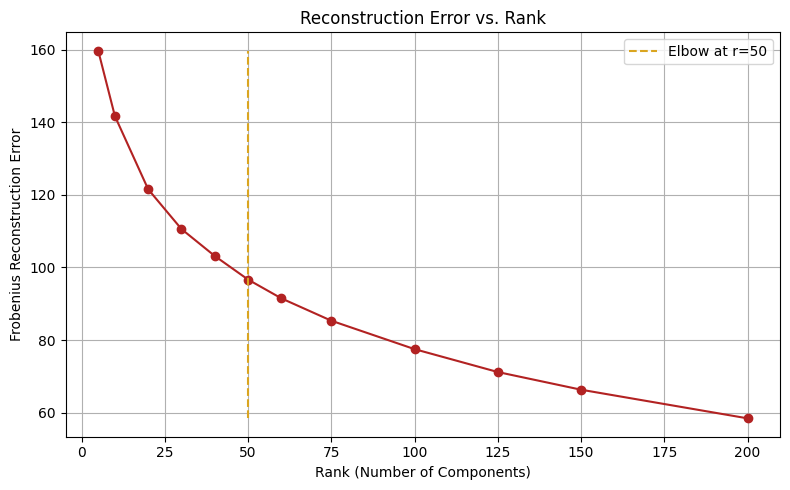

In [6]:
from kneed import KneeLocator

knee = KneeLocator(ranks, errors, curve='convex', direction='decreasing')
print("Elbow at rank:", knee.knee)

# Plot with elbow marked
plt.figure(figsize=(8, 5))
plt.plot(ranks, errors, marker='o',color='firebrick')
plt.vlines(knee.knee, min(errors), max(errors), linestyles='dashed', colors='goldenrod', label=f"Elbow at r={knee.knee}")
plt.title('Reconstruction Error vs. Rank')
plt.xlabel('Rank (Number of Components)')
plt.ylabel('Frobenius Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The terms "knee" and "elbow" from the KneeLocator package both refer to the point of maximum curvature in a curve — often used to find the optimal value of a parameter like the number of components in PCA or NMF, or clusters in K-Means.

The KneeLocator package is a Python utility to automatically detect the "knee" or "elbow" point in a curve — which is usually where increasing a parameter (like rank) gives diminishing returns in reducing error.

They're the same concept, just used for curves with different orientations. Elbow: When the curve is decreasing (like reconstruction error vs. rank). Knee: When the curve is increasing (like explained variance vs. components).

## Basis components and reconstruction


The reconstruction error for rank 20 is: 121.5308


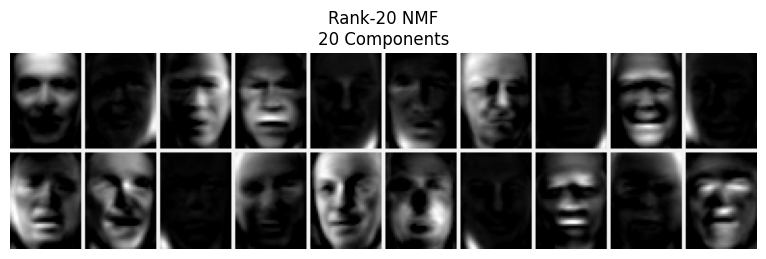

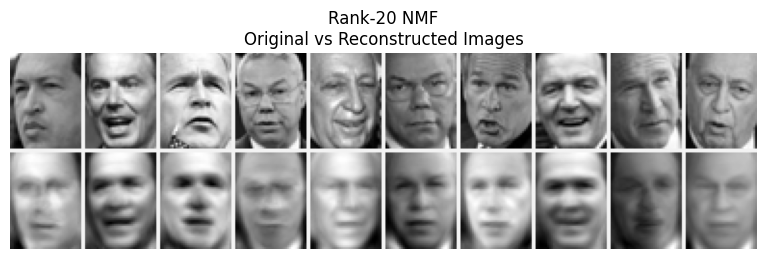

In [7]:
r = 20
data = np.load(f"nmf_models/nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 20
plot_nmf_components(
    W, image_shape=images_shape, 
    n_components=n_components, n_cols=10, 
    title=f"Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

### Rank-50


The reconstruction error for rank 50 is: 96.6585


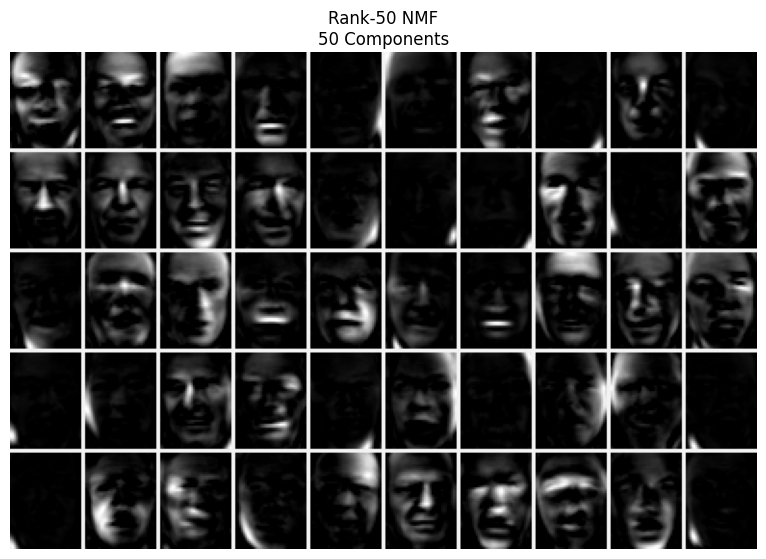

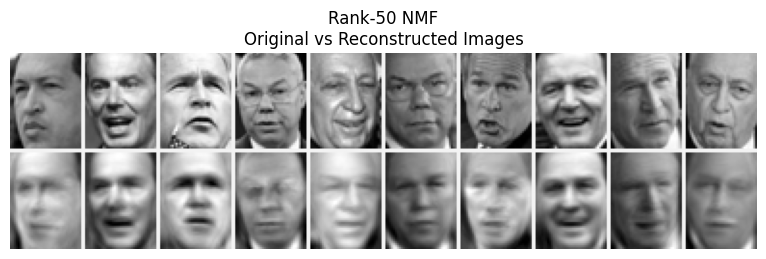

In [8]:
r = 50
data = np.load(f"nmf_models/nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 50
plot_nmf_components(
    W, image_shape=images_shape, 
    n_components=n_components, n_cols=10, 
    title=f"Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

### Rank-250


The reconstruction error for rank 200 is: 58.4350


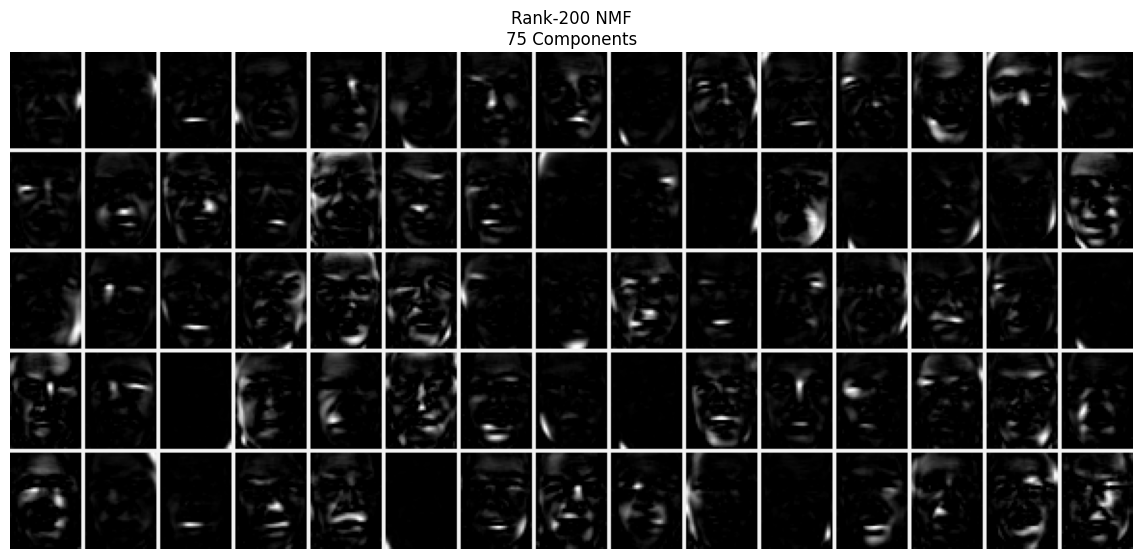

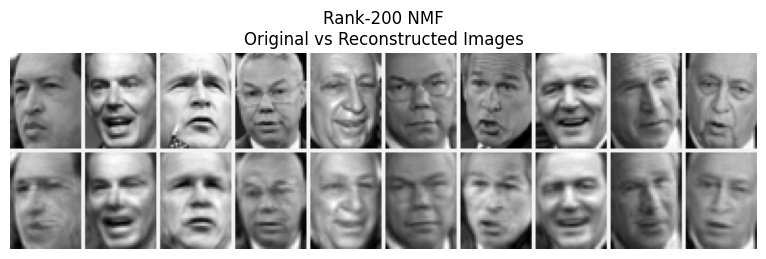

In [9]:
r = 200
data = np.load(f"nmf_models/nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 75
plot_nmf_components(
    W, image_shape=images_shape, 
    n_components=n_components, n_cols=15, 
    title=f"Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"Rank-{r} NMF\nOriginal vs Reconstructed Images"
)